# Zadanie: Kompresja obrazu metodą SVD i rekonstrukcja
**Cel:**
1. Wczytaj plik JPG o rozdzielczości 1920×1080 (lub przeskaluj do tego formatu).
2. Zastosuj kompresję SVD na każdej składowej RGB osobno.
3. Odtwórz obraz używając tylko *k* największych wartości osobliwych.
4. Zapisz wynik do nowego pliku JPG oraz porównaj z oryginałem.

Na dysku dołączono przykładowy obraz: `img_freepik.jpg`.

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def load_image_1920x1080(path):
    img = Image.open(path).convert('RGB')
    if img.size != (1920, 1080):
        img = img.resize((1920, 1080), Image.LANCZOS)
    return np.asarray(img, dtype=np.float64)

def svd_compress_channel(channel: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(channel, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vtk = Vt[:k, :]
    return Uk @ Sk @ Vtk

def svd_reconstruct_rgb(img_array: np.ndarray, k: int):
    R, G, B = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
    Rk = svd_compress_channel(R, k)
    Gk = svd_compress_channel(G, k)
    Bk = svd_compress_channel(B, k)
    out = np.stack([Rk, Gk, Bk], axis=2)
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def psnr(img1: np.ndarray, img2: np.ndarray):
    mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    if mse == 0: return np.inf
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

original_path = Path('img_freepik.jpg')
orig = load_image_1920x1080(original_path)
print('Załadowano:', original_path, orig.shape)

Załadowano: img_freepik.jpg (1080, 1920, 3)


In [10]:
ks = [5, 20, 50, 100, 200, 400]
results = {}
for k in ks:
    rec = svd_reconstruct_rgb(orig, k)
    results[k] = rec
len(results)

6

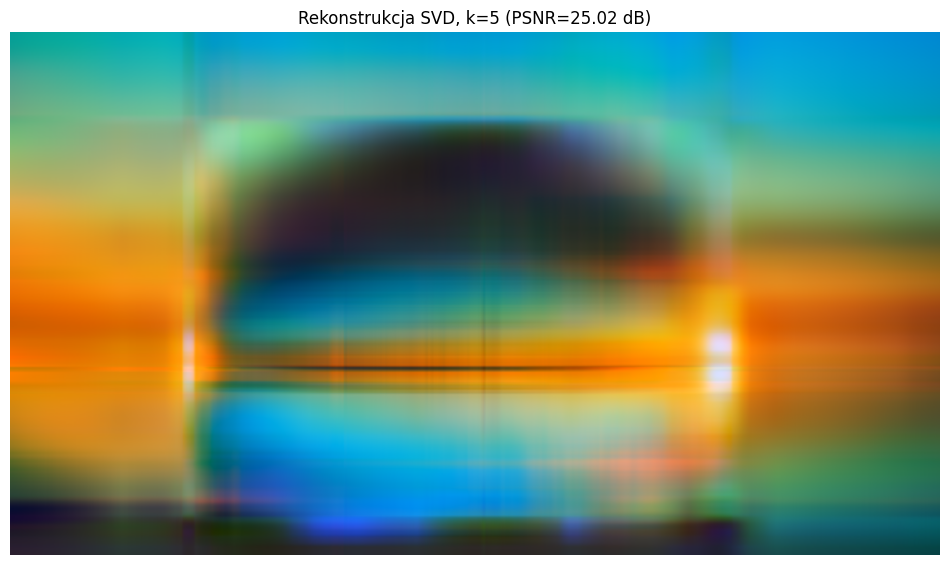

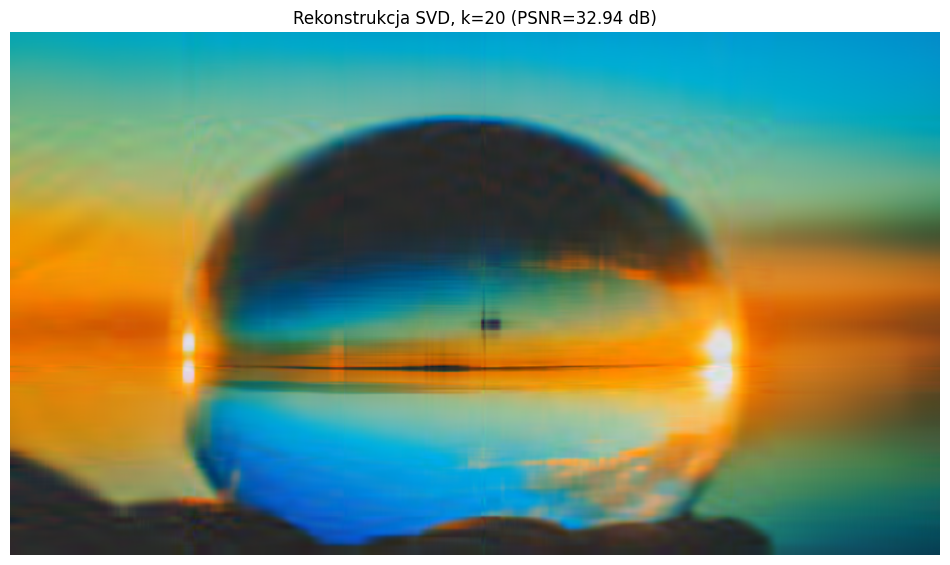

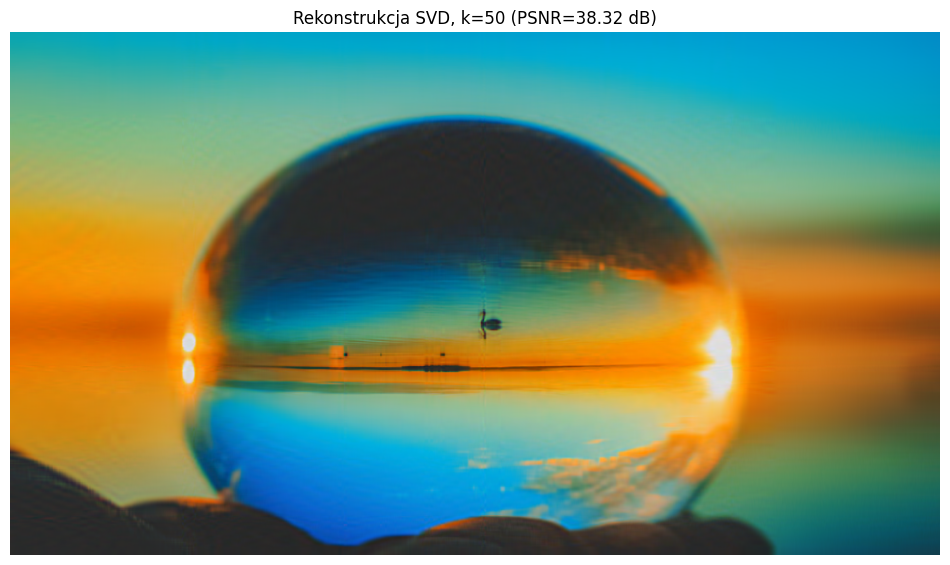

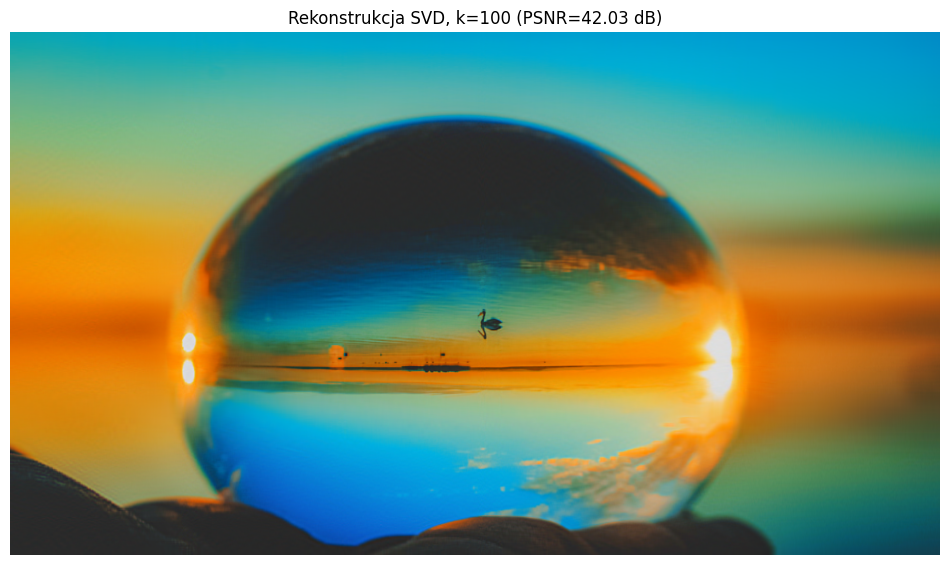

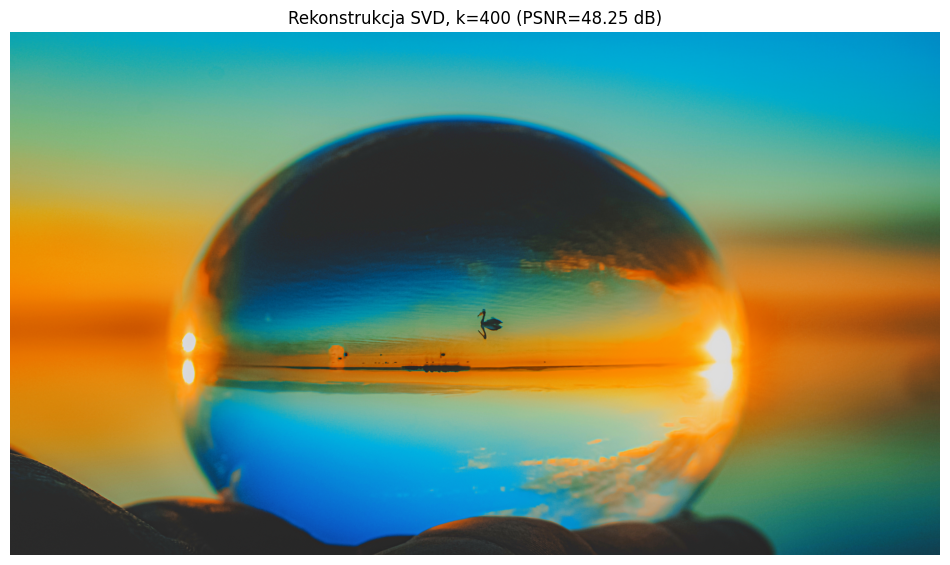

In [11]:
plt.figure(figsize=(12,7))
plt.imshow(orig.astype(np.uint8))
plt.title('Oryginał 1920×1080')
plt.axis('off')
plt.show()

for k in ks:
    plt.figure(figsize=(12,7))
    plt.imshow(results[k])
    plt.title(f'Rekonstrukcja SVD, k={k} (PSNR={psnr(orig, results[k]):.2f} dB)')
    plt.axis('off')
    plt.show()

In [12]:
k_save = 100
save_path = Path(f'svd_reconstruction_k{k_save}.jpg')
Image.fromarray(results[k_save]).save(save_path, quality=95)
save_path

WindowsPath('svd_reconstruction_k100.jpg')